In [1]:
! hdfs dfs -rm -r /data
! hdfs dfs -mkdir -p /data/diabet
! hdfs dfs -put diabetes.csv /data/diabet/db
# ! hdfs dfs -cat /data/diabet/db

Deleted /data


In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StringType, IntegerType, DoubleType, BooleanType
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, CountVectorizer, StringIndexer, IndexToString
from sklearn.metrics import roc_curve
from pyspark.ml.functions import vector_to_array

from tools_plot import get_plot_roc


# В качестве датасета выбран: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
# К сожалению, в датасете нет категориальных переменных, поэтому придумаем их из колонки "Pregnancies"
# путь даже это повлияет на точность результата предсказаний модели.

spark = SparkSession.builder.appName("my_spark").getOrCreate()

schema = StructType() \
    .add("Pregnancies", StringType()) \
    .add("Glucose", IntegerType()) \
    .add("BloodPressure", IntegerType()) \
    .add("SkinThickness", IntegerType()) \
    .add("Insulin", IntegerType()) \
    .add("BMI", DoubleType()) \
    .add("DiabetesPedigreeFunction", DoubleType()) \
    .add("Age", IntegerType()) \
    .add("Outcome", IntegerType())

target_column_name = 'Outcome' # это целевая колонка, которую надо предсказать

df = spark.read.csv(
    "/data/diabet/db",
    header=True,
    schema=schema
)

categorical_columns = [f.name for f in schema.fields if 'StringType' in str(f.typeName)]
number_columns = list(set(schema.fieldNames()) - set(categorical_columns))
number_columns.remove(target_column_name) # убираем целевую колонку
df.show(5)

22/12/09 16:34:13 WARN Utils: Your hostname, alex-pc resolves to a loopback address: 127.0.1.1; using 192.168.1.70 instead (on interface wlan0)


Ivy Default Cache set to: /root/.ivy2/cache

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



In [3]:
stages = [] # стадии пайплайна

def one_hot(stages, categorical_columns, target_name):
    for col in categorical_columns:
        stringIndexer = StringIndexer(inputCol = col, outputCol = col + 'Index').setHandleInvalid("keep")
        encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[col + "classVec"]).setHandleInvalid("keep")
        stages += [stringIndexer, encoder]

one_hot(stages, categorical_columns, target_column_name)

label_stringIdx = StringIndexer(inputCol = target_column_name, outputCol = 'label').setHandleInvalid("keep")
stages += [label_stringIdx]

# объединяем колонки в один вектор, в новую колонку
def vectorize(stages, categorical_columns, number_columns):
    assemblerInputs = [c + "classVec" for c in categorical_columns] + number_columns
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features").setHandleInvalid("keep")
    stages += [assembler]

vectorize(stages, categorical_columns, number_columns)


# обучаем модель
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
stages += [lr]

label_stringIdx_fit = label_stringIdx.fit(df)
indexToStringEstimator = IndexToString().setInputCol("prediction").setOutputCol("category").setLabels(label_stringIdx_fit.labels)

stages += [indexToStringEstimator]

pipeline = Pipeline().setStages(stages)
pipelineModel = pipeline.fit(df)

pipelineModel.write().overwrite().save("my_LR_model")  # сохраняем модель в файл для дальнейших предсказаний

prediction = pipelineModel.transform(df)

print(f'Поля датасета после всех преобразований и предсказаний: {prediction.columns}')

prediction.select('rawPrediction', 'probability', 'Outcome', 'category').show(5)

Поля датасета после всех преобразований и предсказаний: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'PregnanciesIndex', 'PregnanciesclassVec', 'label', 'features', 'rawPrediction', 'probability', 'prediction', 'category']
+--------------------+--------------------+-------+--------+
|       rawPrediction|         probability|Outcome|category|
+--------------------+--------------------+-------+--------+
|[1.64005236673757...|[0.35950724537915...|      1|       1|
|[3.22988374495683...|[0.95386606300692...|      0|       0|
|[1.10401269127191...|[0.16251241054317...|      1|       1|
|[3.32133899136544...|[0.96049337057526...|      0|       0|
|[0.81706903953309...|[0.08145334987872...|      1|       1|
+--------------------+--------------------+-------+--------+
only showing top 5 rows



Точность предсказаний без очистки данных: 0.8427985074626866


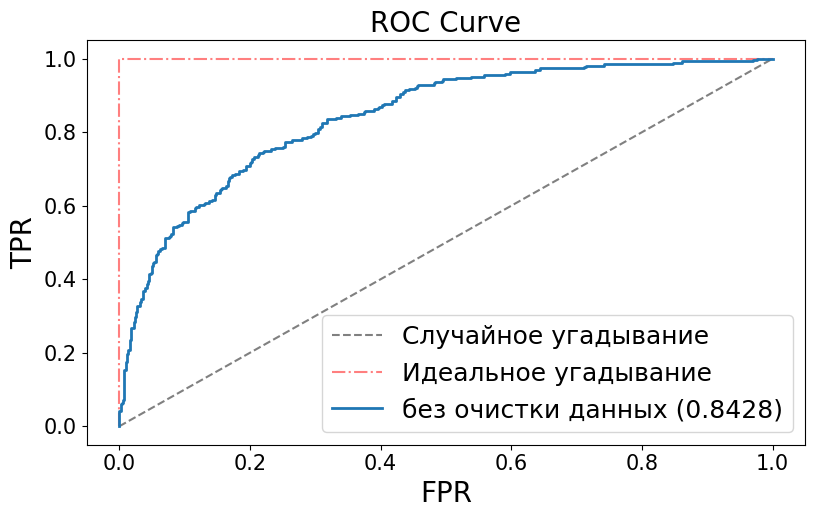

In [5]:
# оцениваем предсказательную силу полученной модели

y_pred = prediction.select(vector_to_array("probability")[1]).rdd.keys().collect()
y_true = prediction.select("label").rdd.keys().collect()


plot, fig, ax, score = get_plot_roc(y_true, y_pred, pos_label=1, title_plot='Лог.регр', title_line='без очистки данных')

print(f'Точность предсказаний без очистки данных: {score}')

plot.show()